In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.metrics import mean_squared_error,r2_score
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn import model_selection

In [2]:
#Bu çalışmada veri seti üzerinde ridge regresyon modelini deneyeceğiz.
#Ridge regresyon modeli hata kareler toplamını küçültmeye çalışır.
#Hata kareler toplamını küçültmek için katsayılara ceza uygular.
#Hata kareler toplamı formülünün üstüne bir de ceza terimi eklenmiştir.
#Tüm değişkenlerle model kurar.İlgisiz değişkenlerin katsayılarını sıfıra yaklaştırır.
#Ceza teriminin katsayısı λ dır. 
#λ için iyi bir değer bulmak önemlidir. Bunun için croos validation yöntemi kullanılır.
#Veri ön işleme aşamalarını yapalım.
data=pd.read_csv("Hitters.csv")
df=data.copy()
df=df.dropna()
dms=pd.get_dummies(df[["League","Division","NewLeague"]])
y=df["Salary"]
x=df.drop(["Salary","League","Division","NewLeague"],axis=1).astype("float64")
x=pd.concat([x,dms[["League_N","Division_W","NewLeague_N"]]],axis=1)
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.25,random_state=42)

In [3]:
#Modeli kuralım.
#Alpha parametresi formüldeki lambda değeridir.Default olarak 1 girilir.
ridge=Ridge(alpha=1).fit(x_train,y_train)

In [4]:
#Modelin sabiti.
ridge.intercept_

-4.082384716969273

In [5]:
#Oluşan modelin kat sayıları.
ridge.coef_

array([ -1.7833362 ,   8.82281559,   7.26631498,  -3.33050119,
        -2.07091307,   5.42111154,   7.50977607,  -0.13557983,
        -0.21962511,  -0.63033482,   1.7974231 ,   0.73919181,
        -0.68443562,   0.26159973,   0.26762087,  -0.48054311,
       102.20055186, -97.88649765, -38.9216579 ])

In [6]:
y_test[:10]

148    850.000
154    277.500
318    875.000
279    150.000
88     260.000
307    277.500
221    210.000
268    140.000
10     517.143
132    325.000
Name: Salary, dtype: float64

In [7]:
ridge.predict(x_test)[:10]

array([ 610.65617195,  693.026009  , 1015.18797916,  408.93538433,
        420.8066687 ,  342.03579451,  659.24206436,  447.06500871,
        911.97037648,  647.245175  ])

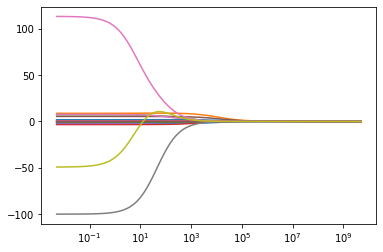

In [8]:
#Lambdanın katsayılar üzerindeki etkisini görmek için bir işlem yapalım.
#İçerisinde 100 tane lambda bulunan bir liste oluşturalım.
#Bu lambdaları kullanarak ridge regresyon modeli oluşturalım ve çıkan katsayıları bir listeye atalım.

lambdalar=10**np.linspace(10,-2,100)*0.5

ridge2=Ridge()
katsayılar=[]

for i in lambdalar:
    ridge2.set_params(alpha=i)
    ridge2.fit(x_train,y_train)
    katsayılar.append(ridge2.coef_)
    
ax=plt.gca()
ax.plot(lambdalar,katsayılar)
ax.set_xscale("log")

#Grafikte her renk bir değişkenin katsayısını ifade etmektedir.
#Görüldüğü gibi lambda değeri arttıkça değişkenlere uygulanan ceza arttığı için değişkenler 0 a yaklaşıyor.
#Model her değişkeni kullandığı için katsayılar 0 olmuyor ama ilgisiz değişken katsayıları 0 a yaklaşıyor.

In [9]:
#Önceki modellerde tuning işlemini brute force yöntemiyle yaptık.
#Rigde regresyom modelinin tuning için özel fonksiyonu var.
from sklearn.linear_model import RidgeCV

In [10]:
#Lambda listemizi oluşturup ridgeCV fonksiyonunu kullandığımız zaman,
#modeli fit ettiğimizde en az hata veren lambda değerini kullanıyor.
lambdalar=10**np.linspace(10,-2,100)*0.5
ridge_cv=RidgeCV(alphas=lambdalar,scoring="neg_mean_squared_error",normalize=True)

In [11]:
ridge_cv.fit(x_train,y_train)

RidgeCV(alphas=array([5.00000000e+09, 3.78231664e+09, 2.86118383e+09, 2.16438064e+09,
       1.63727458e+09, 1.23853818e+09, 9.36908711e+08, 7.08737081e+08,
       5.36133611e+08, 4.05565415e+08, 3.06795364e+08, 2.32079442e+08,
       1.75559587e+08, 1.32804389e+08, 1.00461650e+08, 7.59955541e+07,
       5.74878498e+07, 4.34874501e+07, 3.28966612e+07, 2.48851178e+07,
       1.88246790e+07, 1.42401793e+0...
       3.28966612e-01, 2.48851178e-01, 1.88246790e-01, 1.42401793e-01,
       1.07721735e-01, 8.14875417e-02, 6.16423370e-02, 4.66301673e-02,
       3.52740116e-02, 2.66834962e-02, 2.01850863e-02, 1.52692775e-02,
       1.15506485e-02, 8.73764200e-03, 6.60970574e-03, 5.00000000e-03]),
        cv=None, fit_intercept=True, gcv_mode=None, normalize=True,
        scoring='neg_mean_squared_error', store_cv_values=False)

In [12]:
#Optimum lambda değerine bakalım.
ridge_cv.alpha_

0.7599555414764666

In [13]:
#Optimum lambda değerini bulduktan sonra bu lambda değeriyle modelimizi tekrar kuruyoruz.
ridge_tuned=Ridge(alpha=ridge_cv.alpha_,normalize=True).fit(x_train,y_train)

In [14]:
#Modele test değerlerini tahmin ettirelim ve görselleştirmek için indexleyelim.
y_pred=ridge_tuned.predict(x_test)
y_pred=pd.Series(y_pred,index=x_test.index)

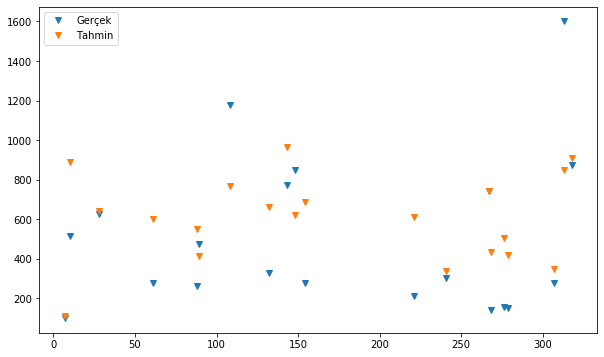

In [15]:
plt.figure(figsize=(10,6))
plt.plot(y_test[:20],"v")
plt.plot(y_pred[:20],"v")
plt.legend(["Gerçek","Tahmin"]);